In [1]:
library(tidyverse) 
library(janitor)
library(patchwork)
library(wordcloud)
library(RColorBrewer)
library(wordcloud2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: RColorBrewer



In [2]:
file_name = "../input/us-accidents/US_Accidents_Dec21_updated.csv"

# Data preparation and cleaning
1. Load the data 
2. Look at the data columns
3. Check for missing values

In [3]:
df=read.csv(file_name)

In [4]:
glimpse(df)

Rows: 2,845,342
Columns: 47
$ ID                    <chr> "A-1", "A-2", "A-3", "A-4", "A-5", "A-6", "A-7",…
$ Severity              <int> 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, …
$ Start_Time            <chr> "2016-02-08 00:37:08", "2016-02-08 05:56:20", "2…
$ End_Time              <chr> "2016-02-08 06:37:08", "2016-02-08 11:56:20", "2…
$ Start_Lat             <dbl> 40.10891, 39.86542, 39.10266, 41.06213, 39.17239…
$ Start_Lng             <dbl> -83.09286, -84.06280, -84.52468, -81.53784, -84.…
$ End_Lat               <dbl> 40.11206, 39.86501, 39.10209, 41.06217, 39.17048…
$ End_Lng               <dbl> -83.03187, -84.04873, -84.52396, -81.53547, -84.…
$ Distance.mi.          <dbl> 3.230, 0.747, 0.055, 0.123, 0.500, 1.427, 0.227,…
$ Description           <chr> "Between Sawmill Rd/Exit 20 and OH-315/Olentangy…
$ Number                <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ Street                <chr> "Outerbelt E", "I-70 E", "I-75 S", "I-77 N", "I-…
$ Side      

In [5]:
summary(df)

      ID               Severity      Start_Time          End_Time        
 Length:2845342     Min.   :1.000   Length:2845342     Length:2845342    
 Class :character   1st Qu.:2.000   Class :character   Class :character  
 Mode  :character   Median :2.000   Mode  :character   Mode  :character  
                    Mean   :2.138                                        
                    3rd Qu.:2.000                                        
                    Max.   :4.000                                        
                                                                         
   Start_Lat       Start_Lng          End_Lat         End_Lng       
 Min.   :24.57   Min.   :-124.55   Min.   :24.57   Min.   :-124.55  
 1st Qu.:33.45   1st Qu.:-118.03   1st Qu.:33.45   1st Qu.:-118.03  
 Median :36.10   Median : -92.42   Median :36.10   Median : -92.42  
 Mean   :36.25   Mean   : -97.11   Mean   :36.25   Mean   : -97.11  
 3rd Qu.:40.16   3rd Qu.: -80.37   3rd Qu.:40.16   3rd Qu.: -80

In [6]:
df = clean_names(df)

In [7]:
df %>%
    summarise(across(everything(), ~ (sum(is.na(.))/nrow(df)) *100  )) %>% 
    pivot_longer(cols = everything(), names_to = "columns", values_to = "na") %>% 
    arrange(desc(na)) %>%
    filter(na > 0) -> na_percentage
na_percentage
    

columns,na
<chr>,<dbl>
number,61.290031
precipitation_in,19.310789
wind_chill_f,16.505678
wind_speed_mph,5.550967
humidity,2.568830
visibility_mi,2.479350
temperature_f,2.434646
pressure_in,2.080593


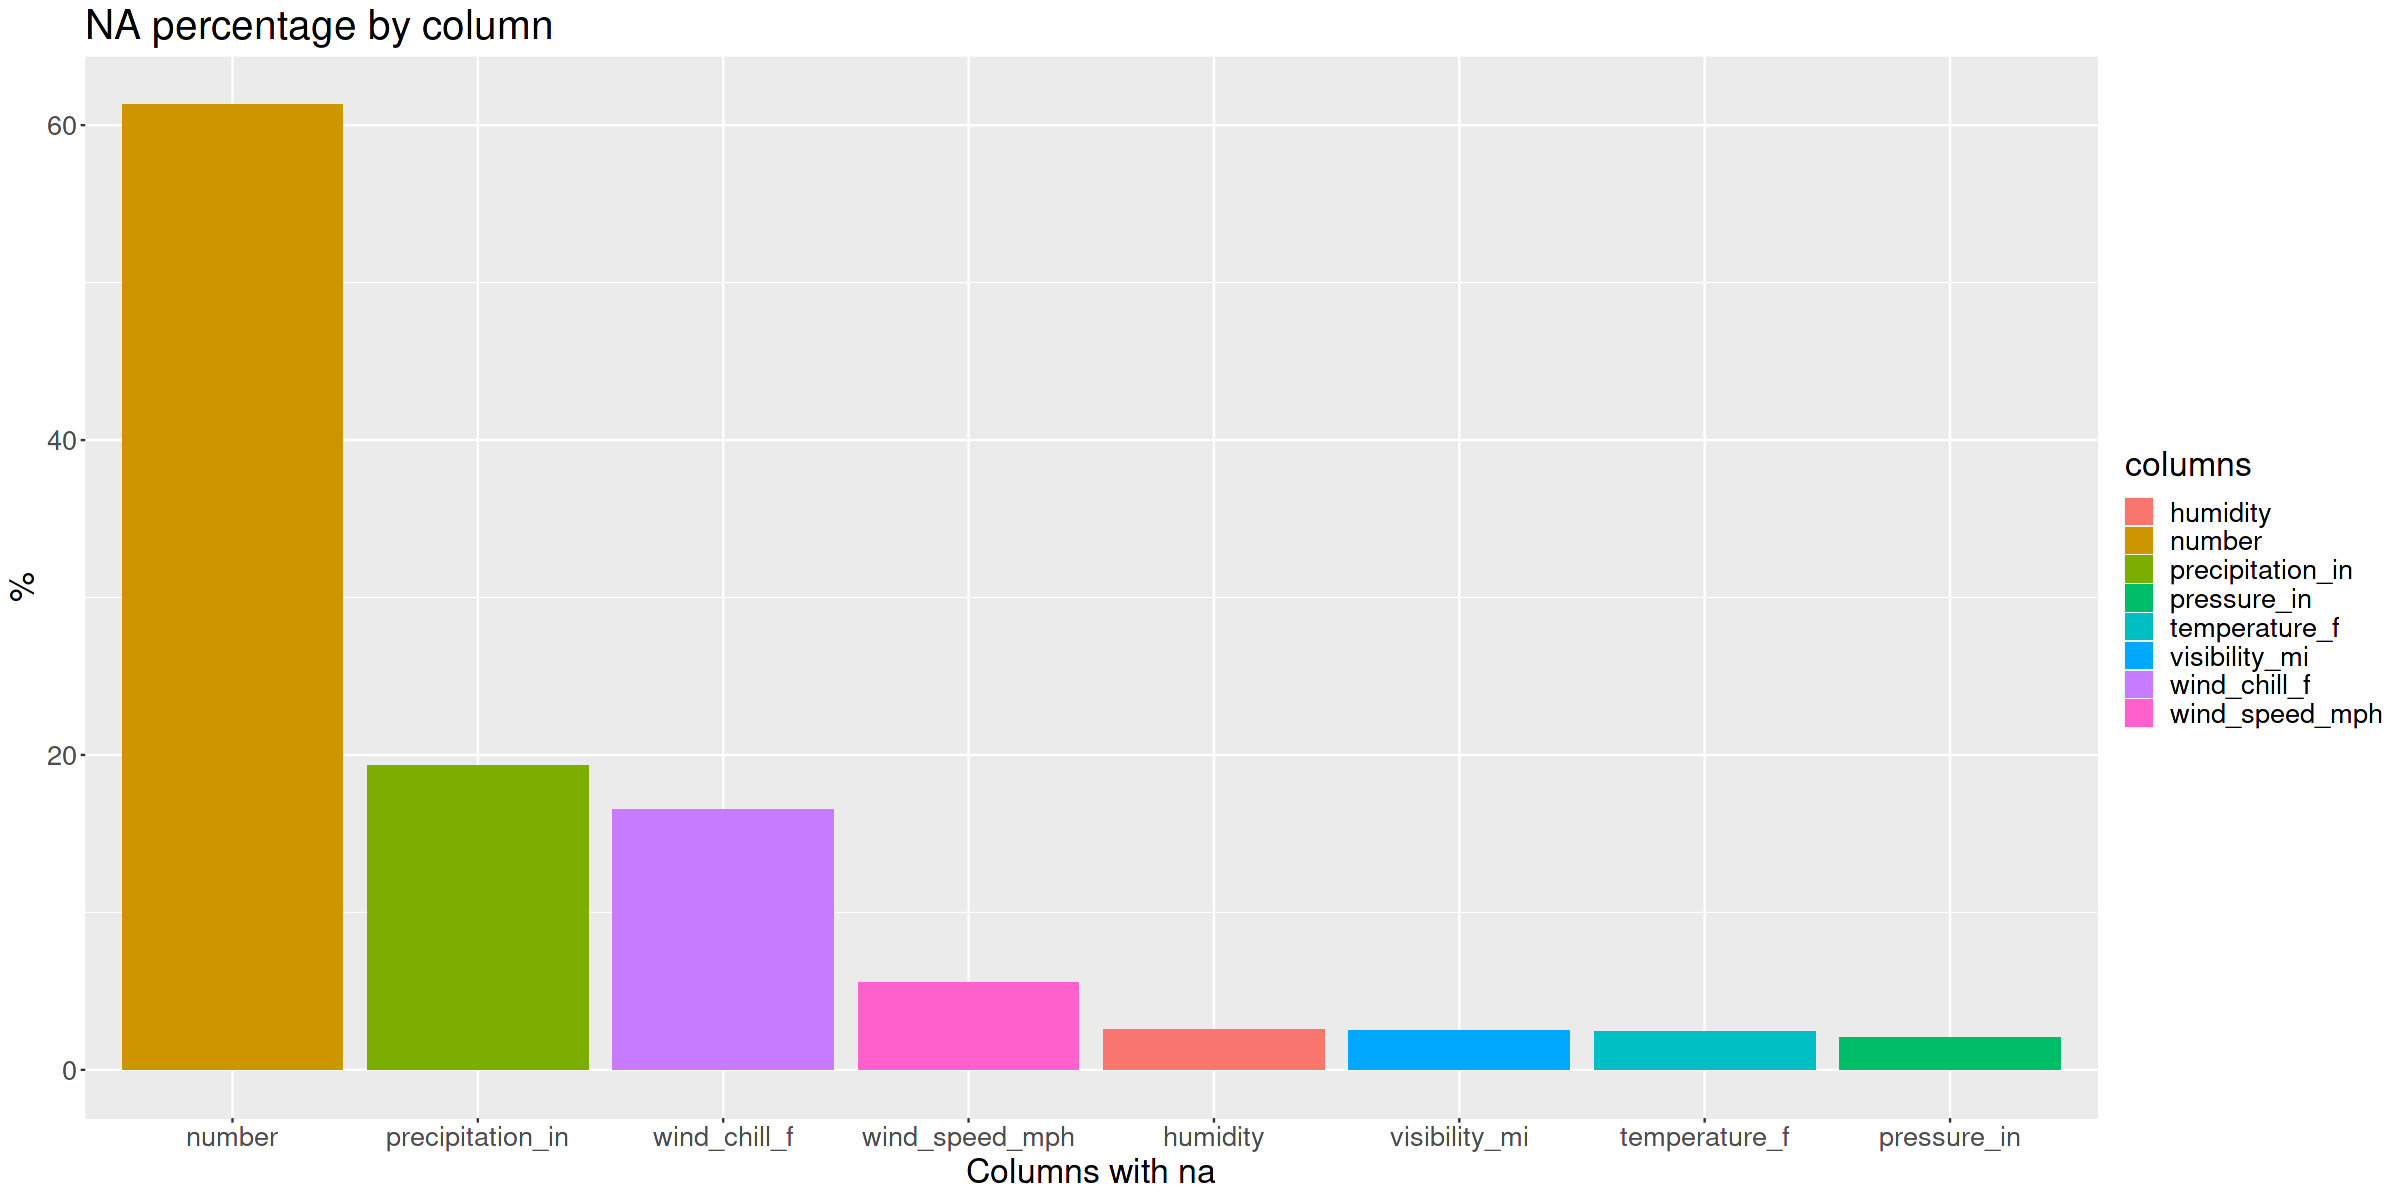

In [8]:
options(repr.plot.width = 20, repr.plot.height = 10)
na_percentage %>% 
    ggplot() + 
    geom_col(mapping = aes(x=reorder(columns, -na), y = na, fill=columns)) + 
    labs(x = "Columns with na", y="%", title ="NA percentage by column")+
    theme(text = element_text(size = 20))

There is a considerable number of  missing values for some of the columns. We will try to avoid this columns in the analysis.

# Exploratory analysis and visualization

The dataset contains 47 different columns, without considering the columns with missing values we have 39 columns to perform the analysis. We'll analyze just some of them.

1. Weather condition
2. Astronomical_Twilight
3. All the POI annotations (Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop)
4. Description

A total of 16 columns will be analyzed.

## Weather condition

In [9]:
glimpse(df$weather_condition)

 chr [1:2845342] "Light Rain" "Light Rain" "Overcast" "Overcast" ...


In [10]:
n_distinct(df$weather_condition)

[1] 128

This column has 128 different categorical values.

In [11]:
df %>% group_by(weather_condition) %>% summarize(count=n()) %>% arrange(-count)

weather_condition,count
<chr>,<int>
Fair,1107194
Mostly Cloudy,363959
Cloudy,348767
Partly Cloudy,249939
Clear,173823
Light Rain,128403
Overcast,84882
,70636
Scattered Clouds,45132


Among some values there's some with an empty character, we'll count them as a missing value.

In [12]:
df$weather_condition[df$weather_condition==""] = NA

Let's take the occurences of each weather condition as a percentage but only those above 1%.

In [13]:
df %>% group_by(weather_condition) %>%
    summarize(percentage=((n()/nrow(df)) * 100)) %>%
    arrange(-percentage) %>%
    filter(percentage > 1) -> weather_conditions_per
weather_conditions_per

weather_condition,percentage
<chr>,<dbl>
Fair,38.912510
Mostly Cloudy,12.791397
Cloudy,12.257472
Partly Cloudy,8.784146
Clear,6.109037
Light Rain,4.512744
Overcast,2.983191
NA,2.482514
Scattered Clouds,1.586171


On the plot we see that most accidents occur on a fair weather with a considerable difference. On weathers with a compromised visibility and road condition (Rain, haze, fog, light snow) there's considerably few accidents.

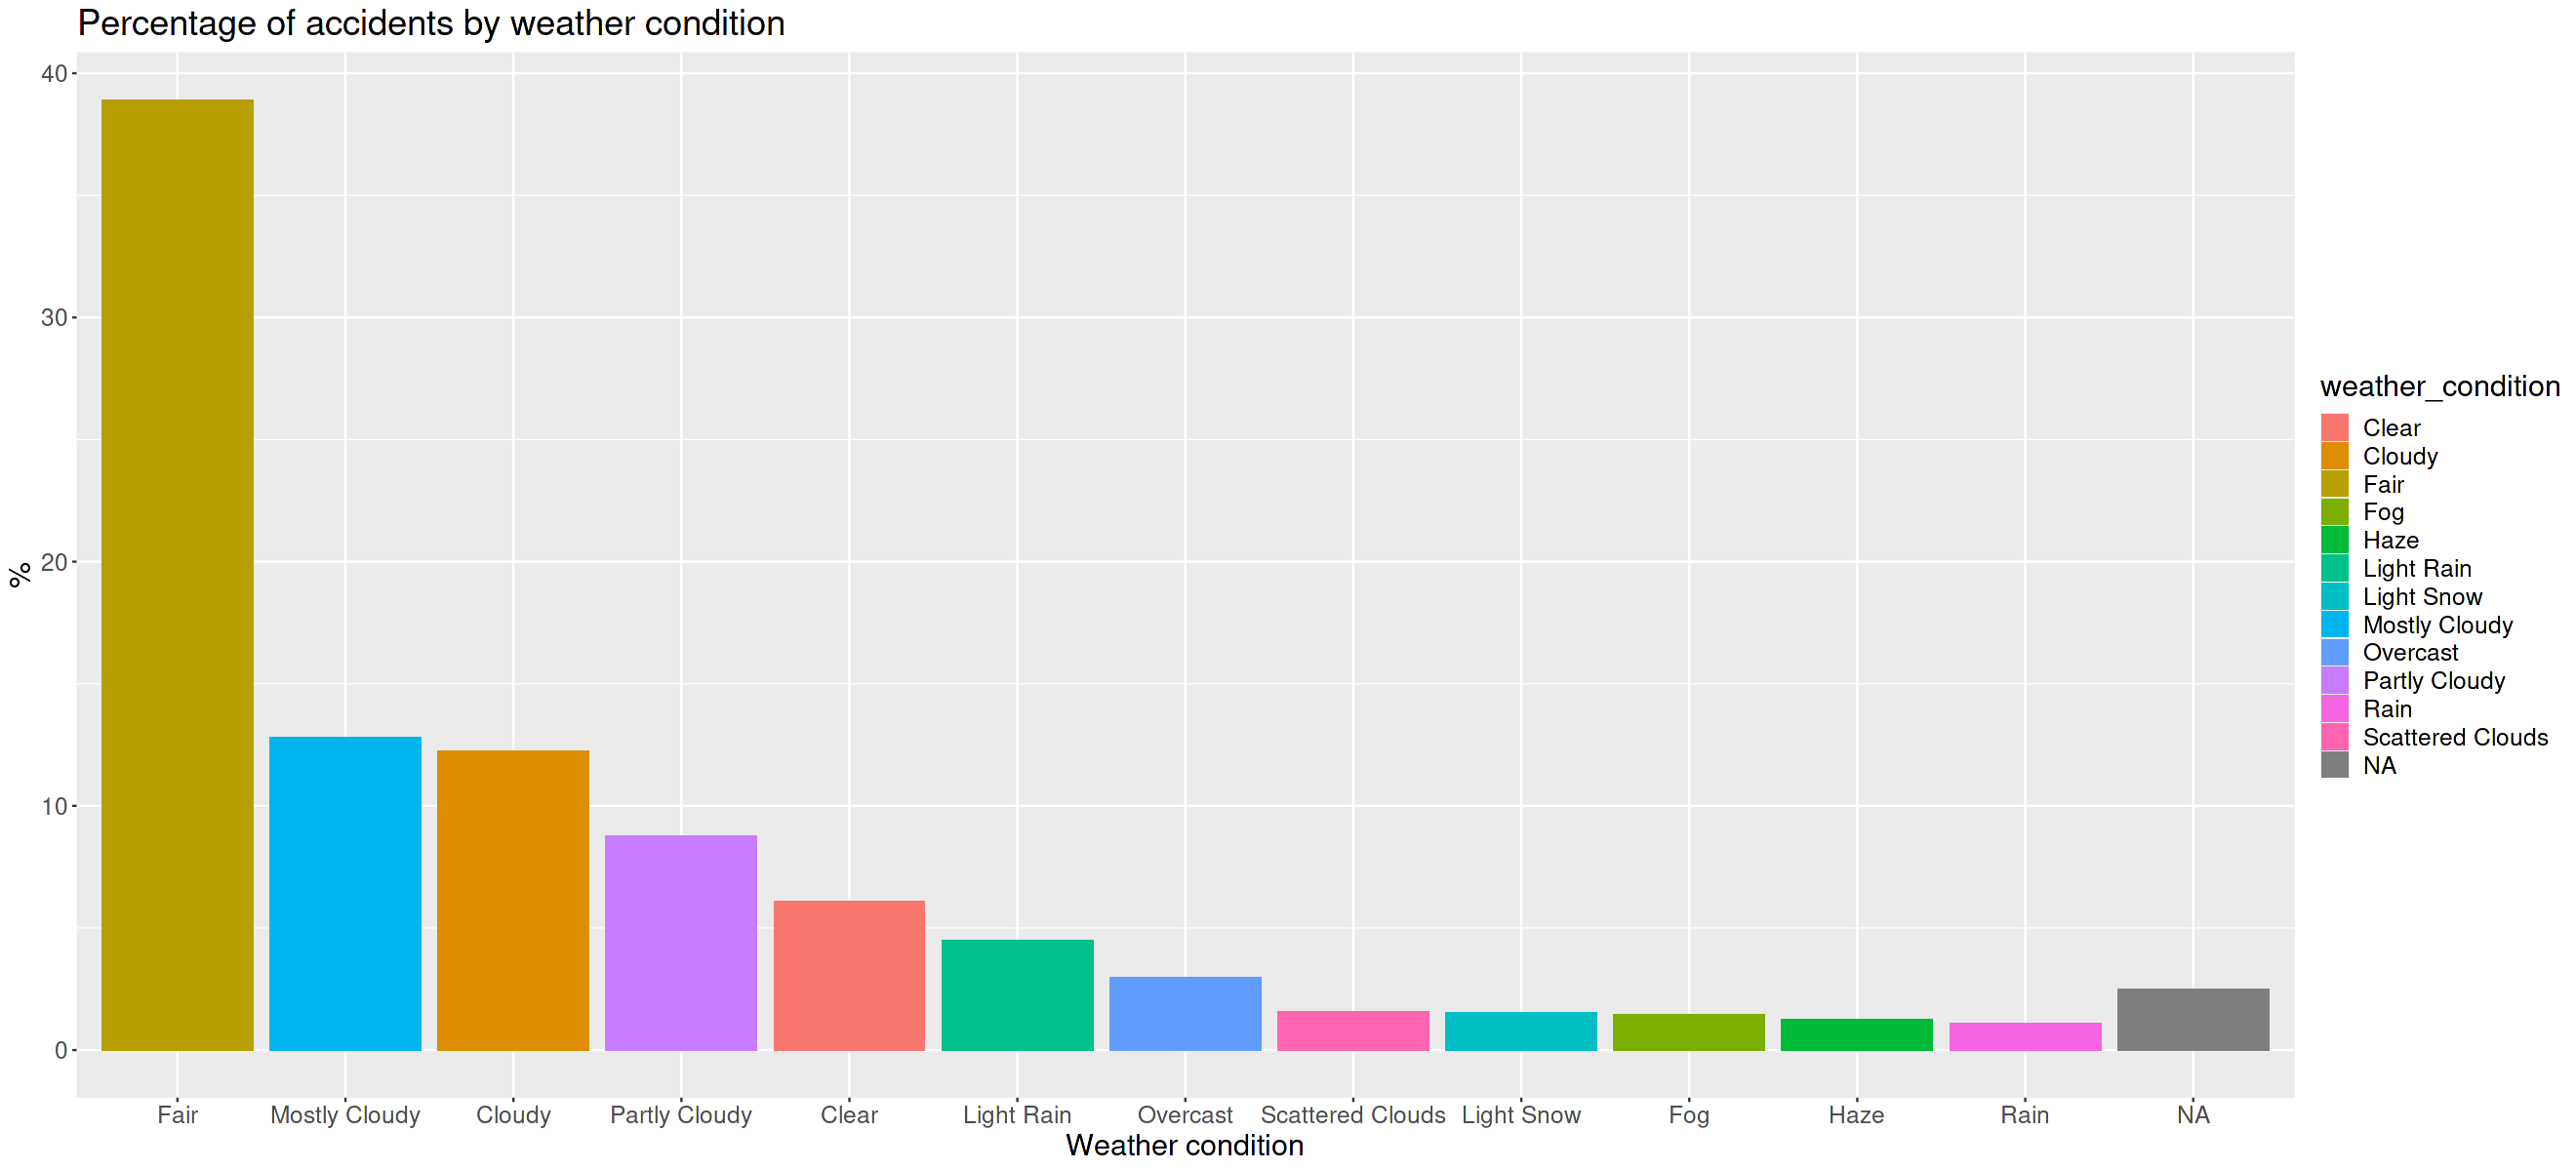

In [14]:
options(repr.plot.width = 22, repr.plot.height = 10)
weather_conditions_per %>% ggplot() +
    geom_col(mapping = aes(x=reorder(weather_condition, -percentage), y = percentage, fill = weather_condition)) + 
    labs(x = "Weather condition", y="%", title ="Percentage of accidents by weather condition") +
    theme(text= element_text(size=18))    

## Astronomical twilight

In [15]:
glimpse(df$astronomical_twilight)

 chr [1:2845342] "Night" "Night" "Day" "Day" "Day" "Day" "Day" "Day" "Day" ...


In [16]:
n_distinct(df$astronomical_twilight)

[1] 3

This column has 3 different categorical values.

In [17]:
df %>% 
    group_by(astronomical_twilight) %>% 
    summarise(count=n()) 

astronomical_twilight,count
<chr>,<int>
,2867
Day,2176983
Night,665492


There's some values with just an empty character too, we will count them as missing values.

In [18]:
df$astronomical_twilight[df$astronomical_twilight==""] = NA

In [19]:
df %>% group_by(astronomical_twilight) %>% summarise(count=n())

astronomical_twilight,count
<chr>,<int>
Day,2176983
Night,665492
NA,2867


Let's take the occurences of as a percentage.

In [20]:
df %>% 
    group_by(astronomical_twilight) %>% 
    summarise(percentage= ((n()/nrow(df))*100) ) -> astronomical_twilight_per
astronomical_twilight_per

astronomical_twilight,percentage
<chr>,<dbl>
Day,76.5104160
Night,23.3888229
NA,0.1007612


On the plot we see that most accidents occur during the day, which makes sense, the flow of traffic is higher during the day than at night.

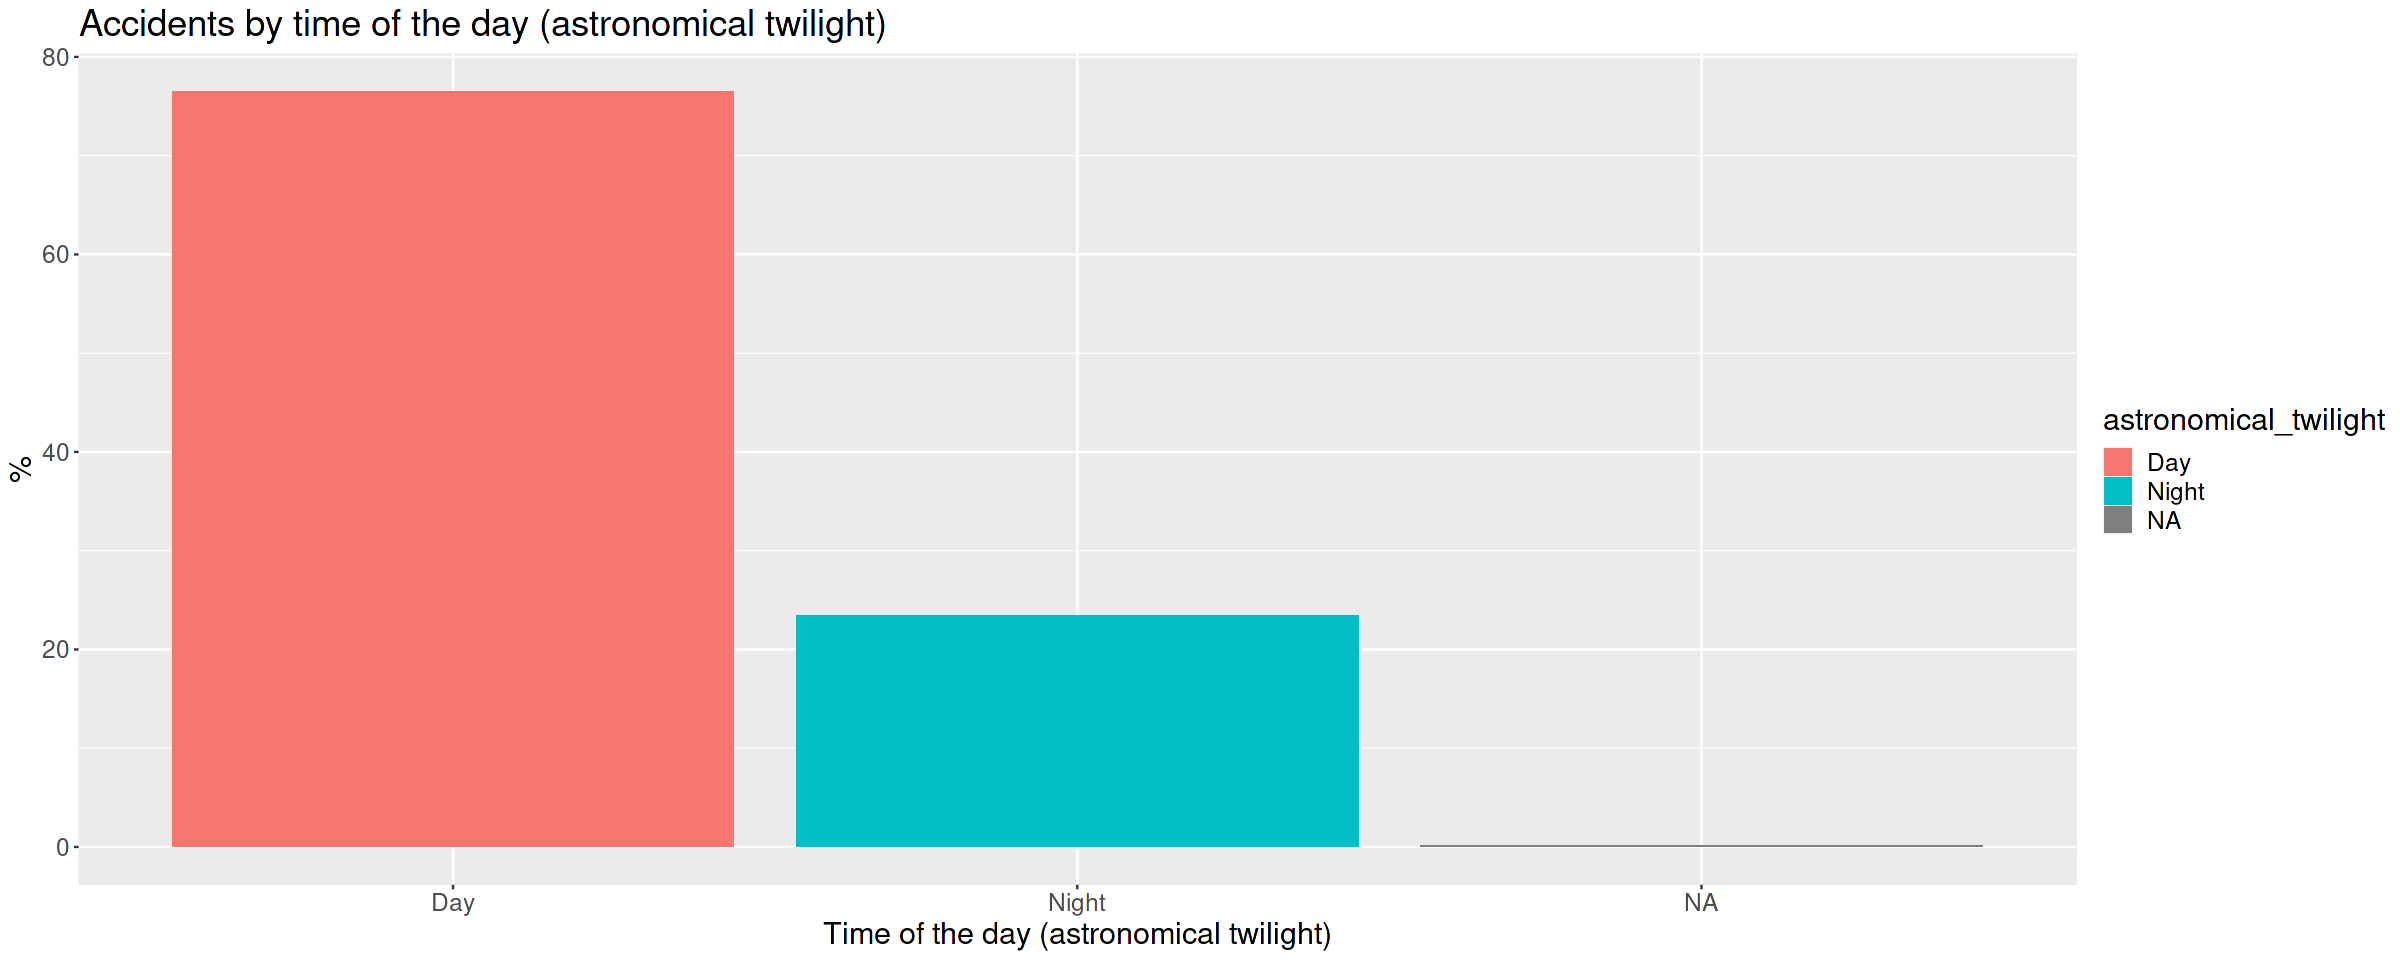

In [21]:
options(repr.plot.width = 20, repr.plot.height = 8)
astronomical_twilight_per %>% ggplot() +
    geom_col(mapping = aes(x=astronomical_twilight, y = percentage, fill=astronomical_twilight)) +
    labs(x = "Time of the day (astronomical twilight)", y="%", title ="Accidents by time of the day (astronomical twilight)") +
    theme(text = element_text(size=18))

## POI annotations


These 13 columns contain 2 different categorical values (True/False) indicating that a road element was nearby the occured accident.

Let's check the occurences of each column and it's combination by percentage and considering only the ones above 1%.

In [22]:
df %>% 
    group_by(amenity, bump, crossing, give_way, junction, no_exit, railway, roundabout, station, stop, traffic_calming, traffic_signal, turning_loop) %>%
    summarise(percentage = n()/nrow(df) *100 ) %>%
    arrange(-percentage) %>%
    filter(percentage > 1) -> accidents_per_roadelement
accidents_per_roadelement

`summarise()` has grouped output by 'amenity', 'bump', 'crossing', 'give_way',
'junction', 'no_exit', 'railway', 'roundabout', 'station', 'stop',
'traffic_calming', 'traffic_signal'. You can override using the `.groups`
argument.


amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,percentage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
False,False,False,False,False,False,False,False,False,False,False,False,False,74.189289
False,False,False,False,True,False,False,False,False,False,False,False,False,9.901235
False,False,False,False,False,False,False,False,False,False,False,True,False,4.939828
False,False,True,False,False,False,False,False,False,False,False,True,False,2.985160
False,False,True,False,False,False,False,False,False,False,False,False,False,2.081683
False,False,False,False,False,False,False,False,False,True,False,False,False,1.199821
False,False,False,False,False,False,False,False,True,False,False,False,False,1.096459


Let's create a tibble with the elements name and their corresponding percentage to plot it.

In [23]:
acc_road_element_per <- tibble(c("None", "Junction", "Traffic signal", "Crossing and traffic signal", "Crossing", "Stop", "Station" ), 
       pull(accidents_per_roadelement, percentage), .name_repair = ~ c("road_elements", "percentage"))
acc_road_element_per

road_elements,percentage
<chr>,<dbl>
None,74.189289
Junction,9.901235
Traffic signal,4.939828
Crossing and traffic signal,2.985160
Crossing,2.081683
Stop,1.199821
Station,1.096459


On the plot we can see that most accidents occur close to none of the road elements considered on the dataset followed by junctions , traffic signals and crossing with traffic signal.

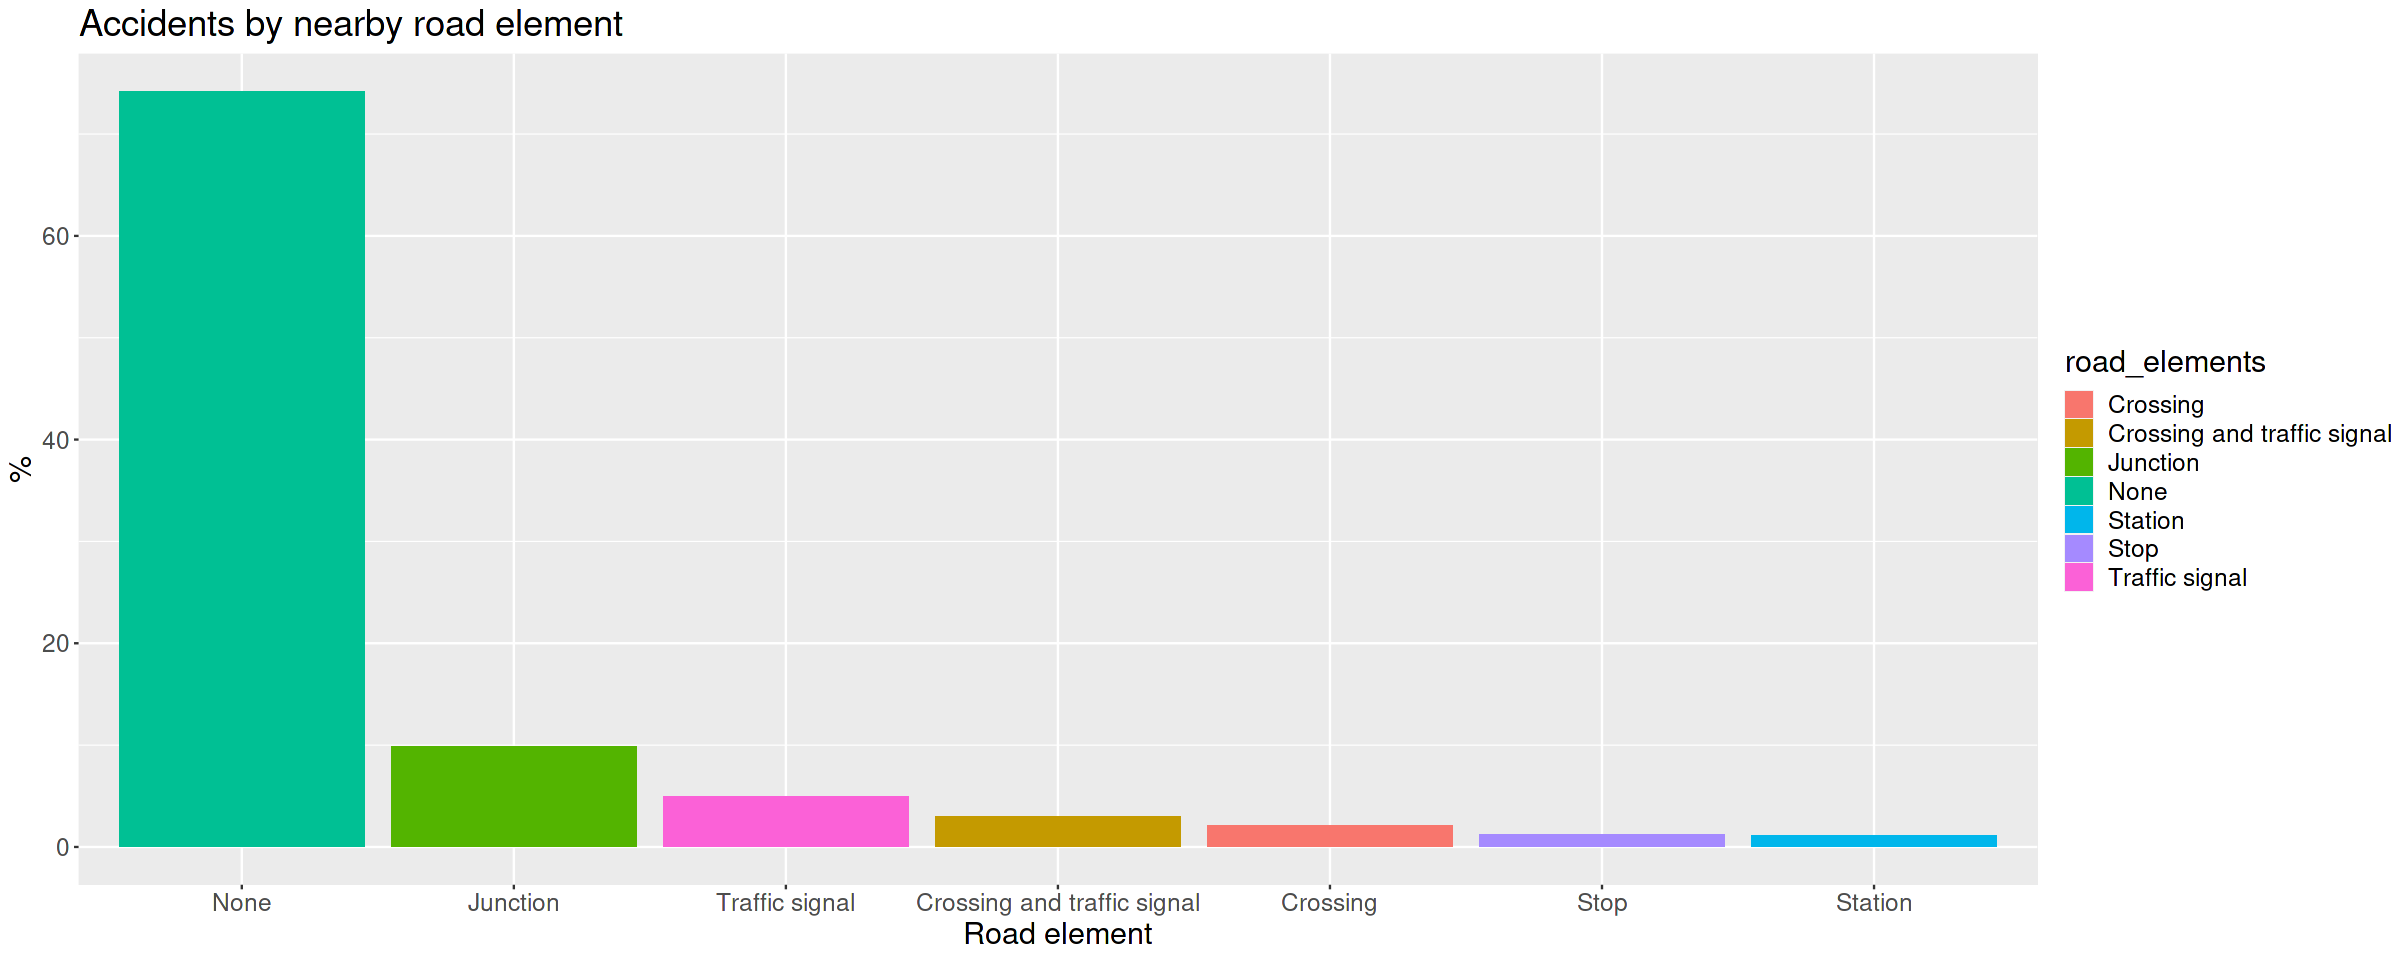

In [24]:
options(repr.plot.width = 20, repr.plot.height = 8)
acc_road_element_per %>%
    ggplot() +
    geom_col(mapping = aes(x=reorder(road_elements, -percentage), y=percentage, fill = road_elements)) +
    labs(x = "Road element", y="%", title ="Accidents by nearby road element") +
    theme(text = element_text(size=18))

## Severity

The severity is the impact of the accident on traffic.

In [25]:
glimpse(df$severity)

 int [1:2845342] 3 2 2 2 3 2 2 2 2 2 ...


In [26]:
n_distinct(df$severity)

[1] 4

There's 4 grades of severity, being 1 the lowest and 4 the heighest.

Let's calculate the ocurrences of each value by percentage.

In [27]:
df %>%
    group_by(severity) %>%
    summarise(percentage = n() / nrow(df) *100) -> severity_per
severity_per

severity,percentage
<int>,<dbl>
1,0.9156369
2,89.0223741
3,5.4511901
4,4.6107990


On the plot wi can see that the most recurrent severity is 2 by a large difference.

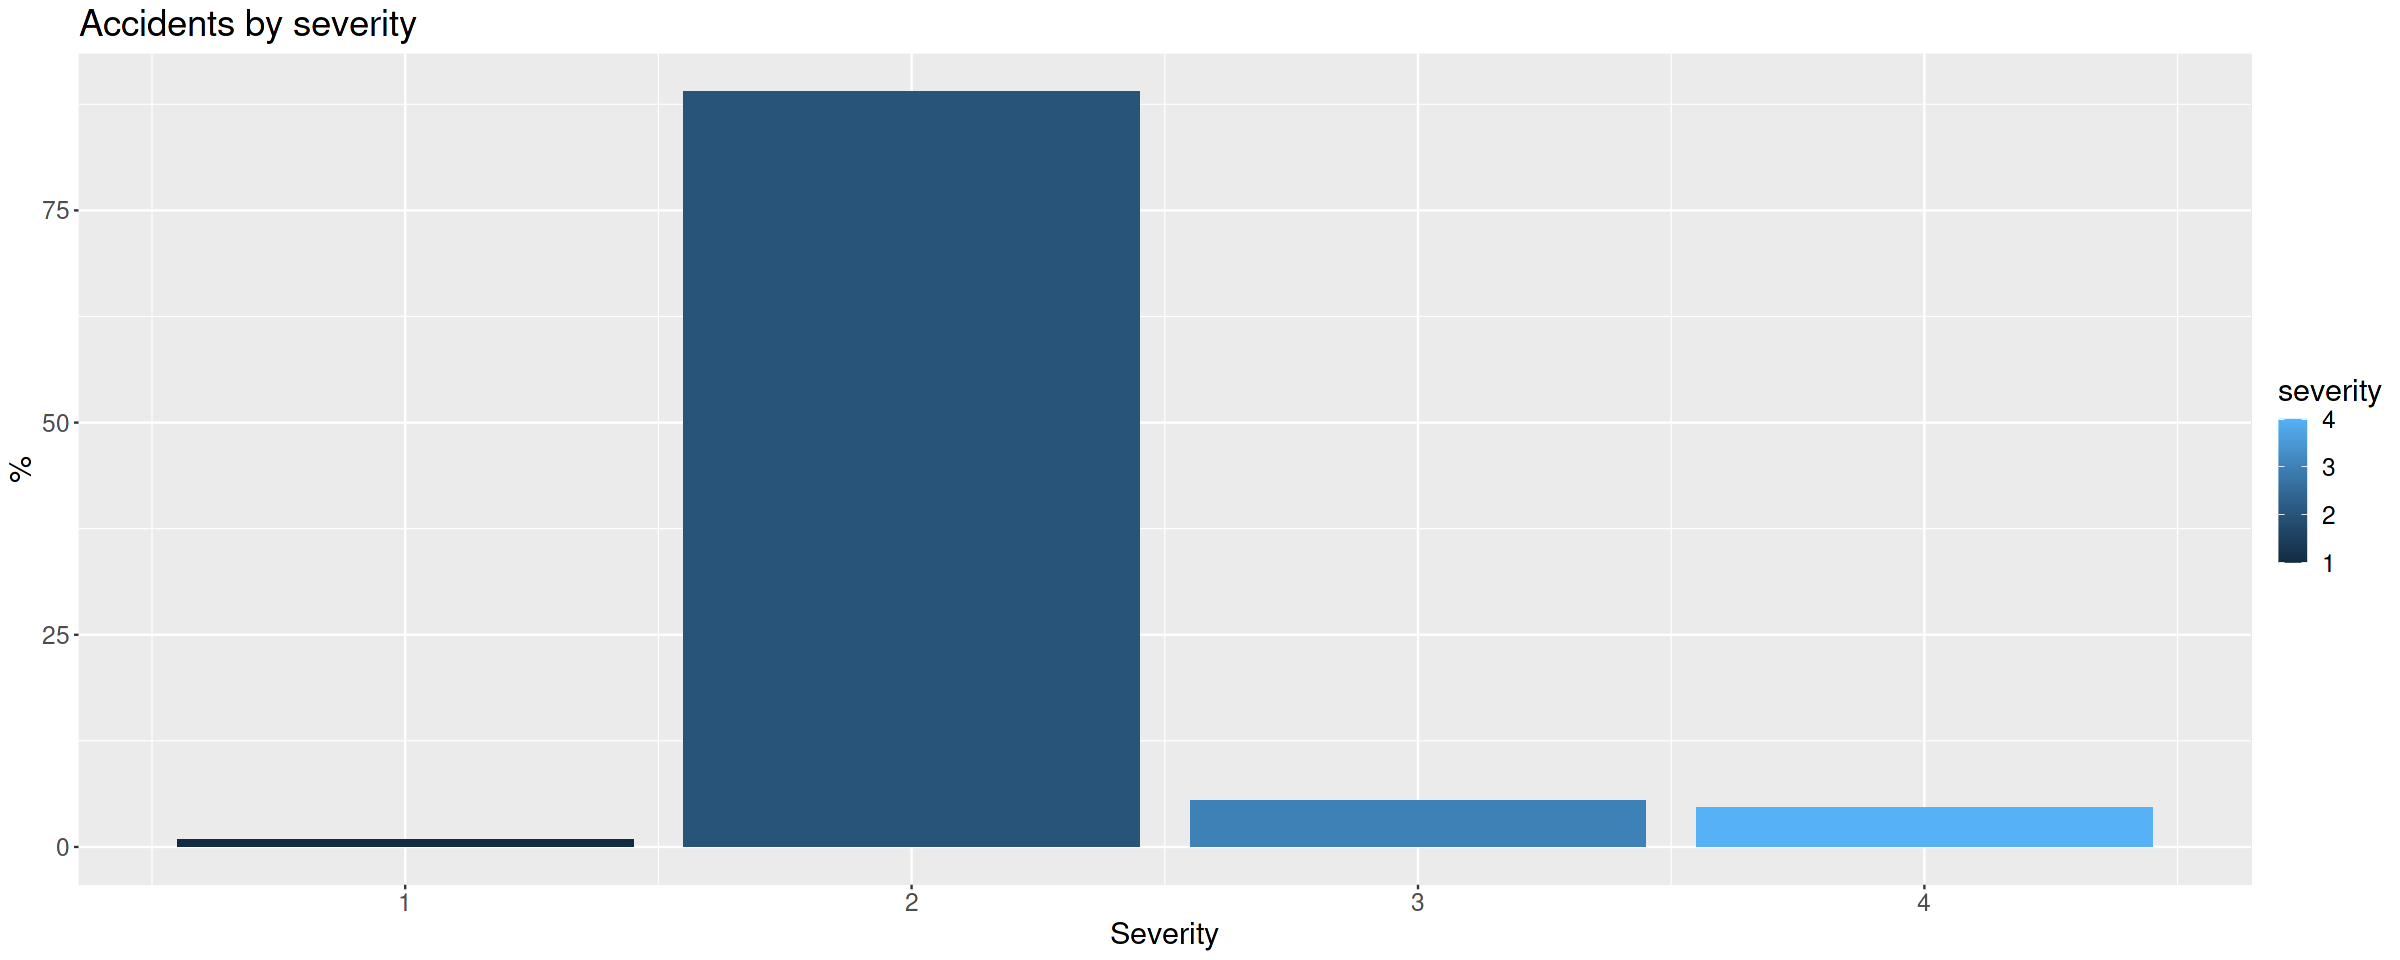

In [28]:
options(repr.plot.width = 20, repr.plot.height = 8)
severity_per %>%
    ggplot() + 
    geom_col(mapping = aes(x=severity, y=percentage, fill=severity)) +
    labs(x = "Severity", y="%", title ="Accidents by severity") +
    theme(text = element_text(size=18))

### Severity and weather condition

Now, we will take the severity of the accidents and see how the weather conditions affect it.

Specifically we will see the distribution of each severity with the weather conditions.

In [29]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==4) %>%
    summarise(count = n()) %>%
    ggplot() +
    geom_density(mapping = aes(x=count))+
    scale_x_log10() + 
    theme(text = element_text(size=18)) +
    labs(x = "Weather condition", y="Density", title ="Density of severity 4 acccidents by weather condition")-> weather_severity4_dis


In [30]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==3) %>%
    summarise(count = n()) %>%
    ggplot() +
    geom_density(mapping = aes(x=count))+
    scale_x_log10() + 
    theme(text = element_text(size=18)) +
    labs(x = "Weather condition", y="Density", title ="Density of severity 3 acccidents by weather condition")-> weather_severity3_dis

In [31]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==2) %>%
    summarise(count = n()) %>%
    ggplot() +
    geom_density(mapping = aes(x=count)) +
    scale_x_log10() + 
    theme(text = element_text(size=18))+
    labs(x = "Weather condition", y="Density", title ="Density of severity 2 acccidents by weather condition")-> weather_severity2_dis

In [32]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==1) %>%
    summarise(count = n()) %>%
    ggplot() +
    geom_density(mapping = aes(x=count))+
    scale_x_log10() + 
    theme(text = element_text(size=18)) +
    labs(x = "Weather condition", y="Density", title ="Density of severity 1 acccidents by weather condition") -> weather_severity1_dis

The distributions are very similar there's many weather conditions with few accidents and few weather conditions with many accidents. The form of the curve is similar between 4, 3, and 1 but not so similar with 2. However, is not extremly different to say that there's a completely different fenomenon occurring with severity 2. 

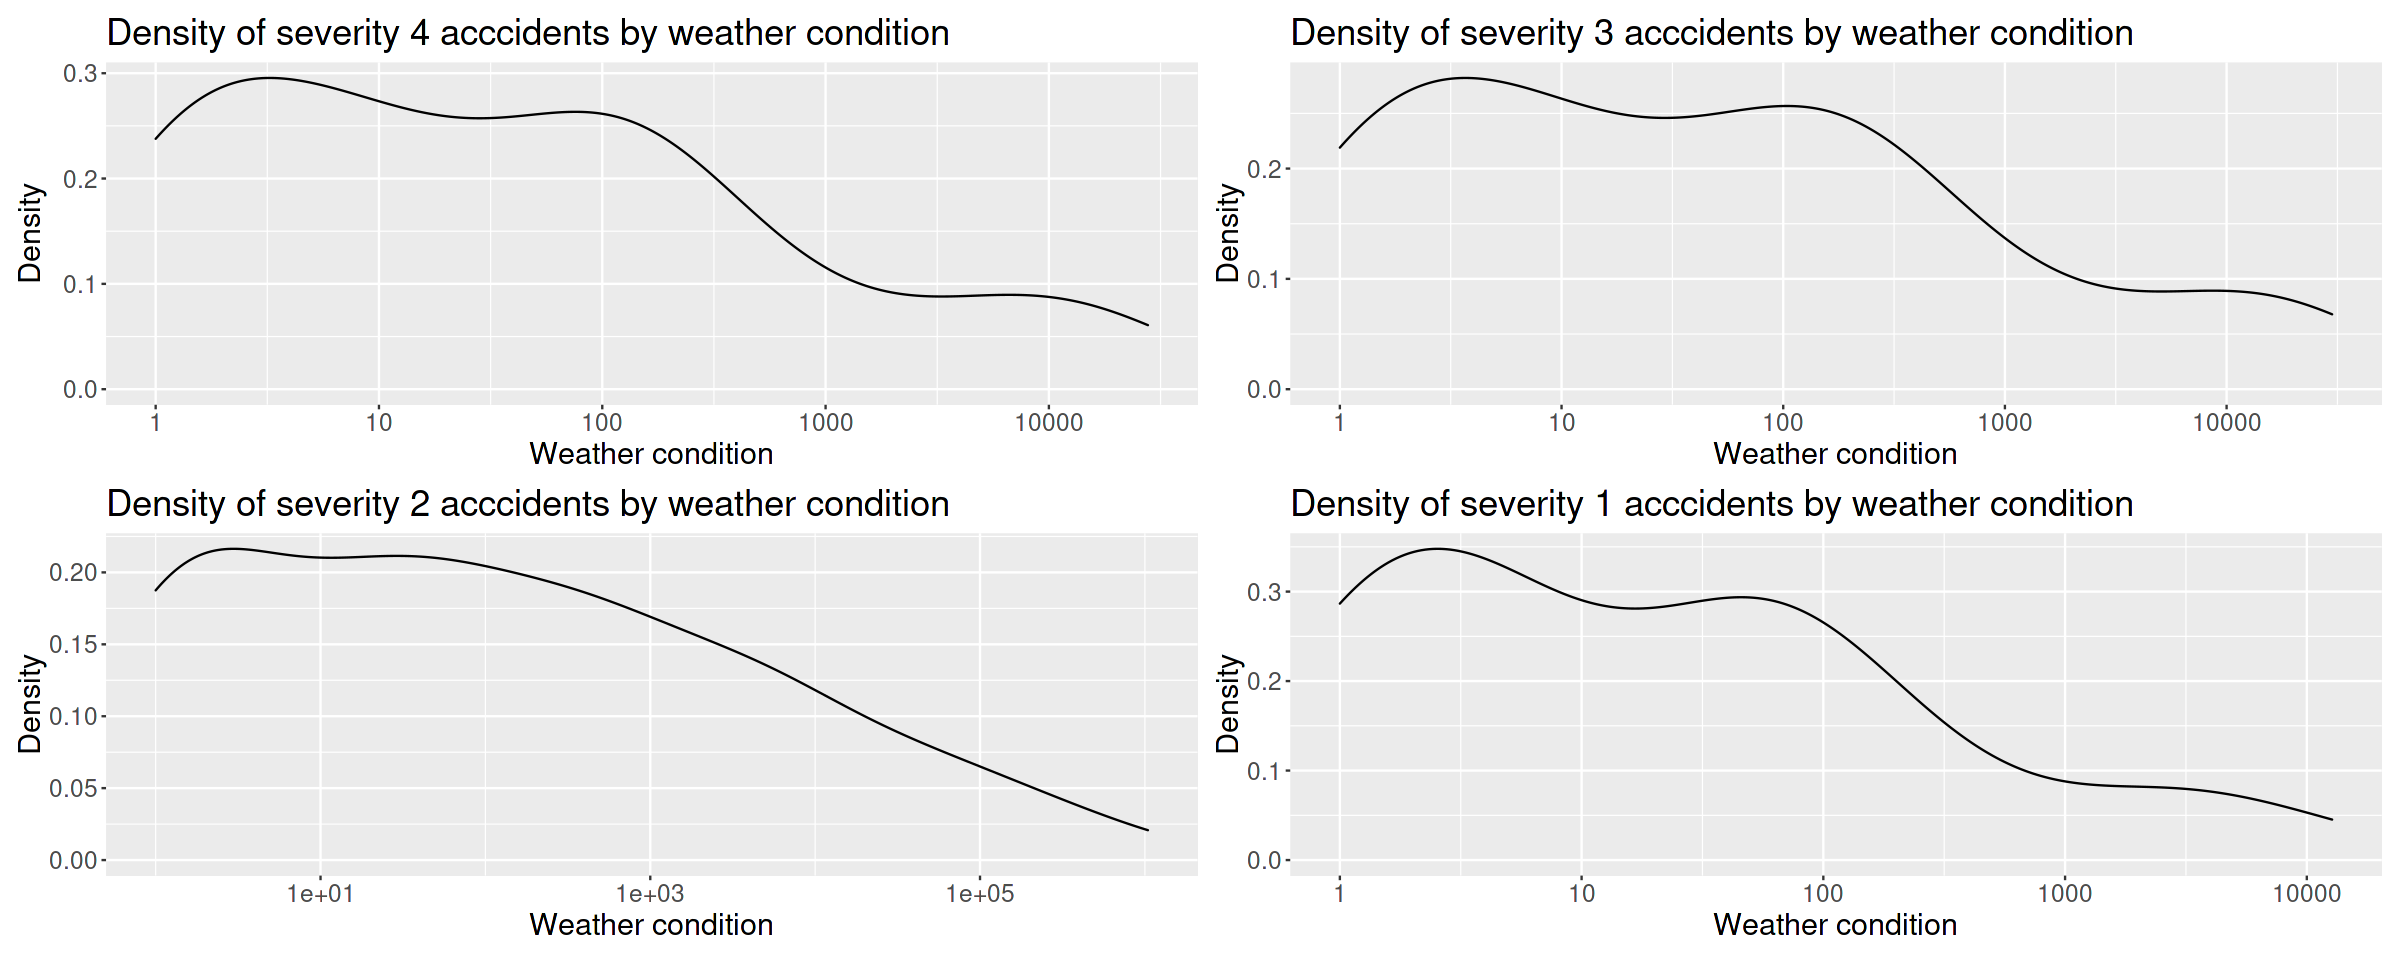

In [33]:
options(repr.plot.width = 20, repr.plot.height = 8)
weather_severity4_dis + weather_severity3_dis + weather_severity2_dis + weather_severity1_dis

To understand better what's going on we have to see which weather conditions has more accidents for each severity for percentages higher than 1.

In [34]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==4) %>%
    summarise(count = n()/nrow(.)*100) %>%
    filter(count>1)%>%
    arrange(-count) -> severity4_weather
severity4_weather

weather_condition,count
<chr>,<dbl>
Fair,21.163477
Clear,19.254838
Mostly Cloudy,11.957955
Overcast,10.075233
Cloudy,8.591922
Partly Cloudy,7.747365
Light Rain,4.595520
Scattered Clouds,4.301297
NA,3.360698


In [35]:
options(repr.plot.width = 20, repr.plot.height = 8)
severity4_weather %>%
    ggplot() +
    geom_col(mapping=aes(x=reorder(weather_condition, -count), y=count, fill=weather_condition))+ 
    theme(text = element_text(size=18)) +
    labs(x = "Weather condition", y="%", title ="Severity 4 acccidents by weather condition")-> severity4_weather_plot

In [36]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==3) %>%
    summarise(count = n()/nrow(.)*100) %>%
    filter(count>1)%>%
    arrange(-count) -> severity3_weather
severity3_weather

weather_condition,count
<chr>,<dbl>
Clear,19.292737
Mostly Cloudy,15.680346
Fair,15.103317
Overcast,10.412301
Partly Cloudy,10.270462
Cloudy,7.124851
Scattered Clouds,5.614906
Light Rain,5.527223
NA,2.550530


In [37]:
options(repr.plot.width = 20, repr.plot.height = 8)
severity3_weather %>%
    ggplot() +
    geom_col(mapping=aes(x=reorder(weather_condition, -count), y=count, fill=weather_condition))+ 
    theme(text = element_text(size=18)) +
    labs(x = "Weather condition", y="%", title ="Severity 3 acccidents by weather condition") -> severity3_weather_plot

In [38]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==2) %>%
    summarise(count = n()/nrow(.)*100) %>%
    filter(count>1)%>%
    arrange(-count) -> severity2_weather
severity2_weather

weather_condition,count
<chr>,<dbl>
Fair,41.187553
Cloudy,12.760132
Mostly Cloudy,12.614534
Partly Cloudy,8.738997
Clear,4.683712
Light Rain,4.441548
NA,2.444659
Overcast,2.191638
Fog,1.522903


In [39]:
options(repr.plot.width = 20, repr.plot.height = 8)
severity2_weather %>%
    ggplot() +
    geom_col(mapping=aes(x=reorder(weather_condition, -count), y=count, fill=weather_condition))+ 
    theme(text = element_text(size=18)) +
    labs(x = "Weather condition", y="%", title ="Severity 2 acccidents by weather condition") -> severity2_weather_plot

In [40]:
df %>%
    group_by(weather_condition) %>%
    filter(severity==1) %>%
    summarise(count = n()/nrow(.)*100) %>%
    filter(count>1)%>%
    arrange(-count) -> severity1_weather
severity1_weather

weather_condition,count
<chr>,<dbl>
Fair,48.846582
Mostly Cloudy,16.984608
Cloudy,12.401643
Partly Cloudy,9.545926
Light Rain,4.978313
NA,1.335739


In [41]:
severity1_weather %>%
    ggplot() +
    geom_col(mapping=aes(x=reorder(weather_condition, -count), y=count, fill=weather_condition))+ 
    theme(text = element_text(size=18))+
    labs(x = "Weather condition", y="%", title ="Severity 1 acccidents by weather condition")-> severity1_weather_plot

On the plot we can see the ocurrences for each severity by weather condition. With fair weather occur the most accidents of almost all severities. We can see that weathers with no compromised visibility or road condition are the most recurrent on all severities. Also, we can see that weathers with compromised visibility or road condition are not recurrent not even on highest severities.

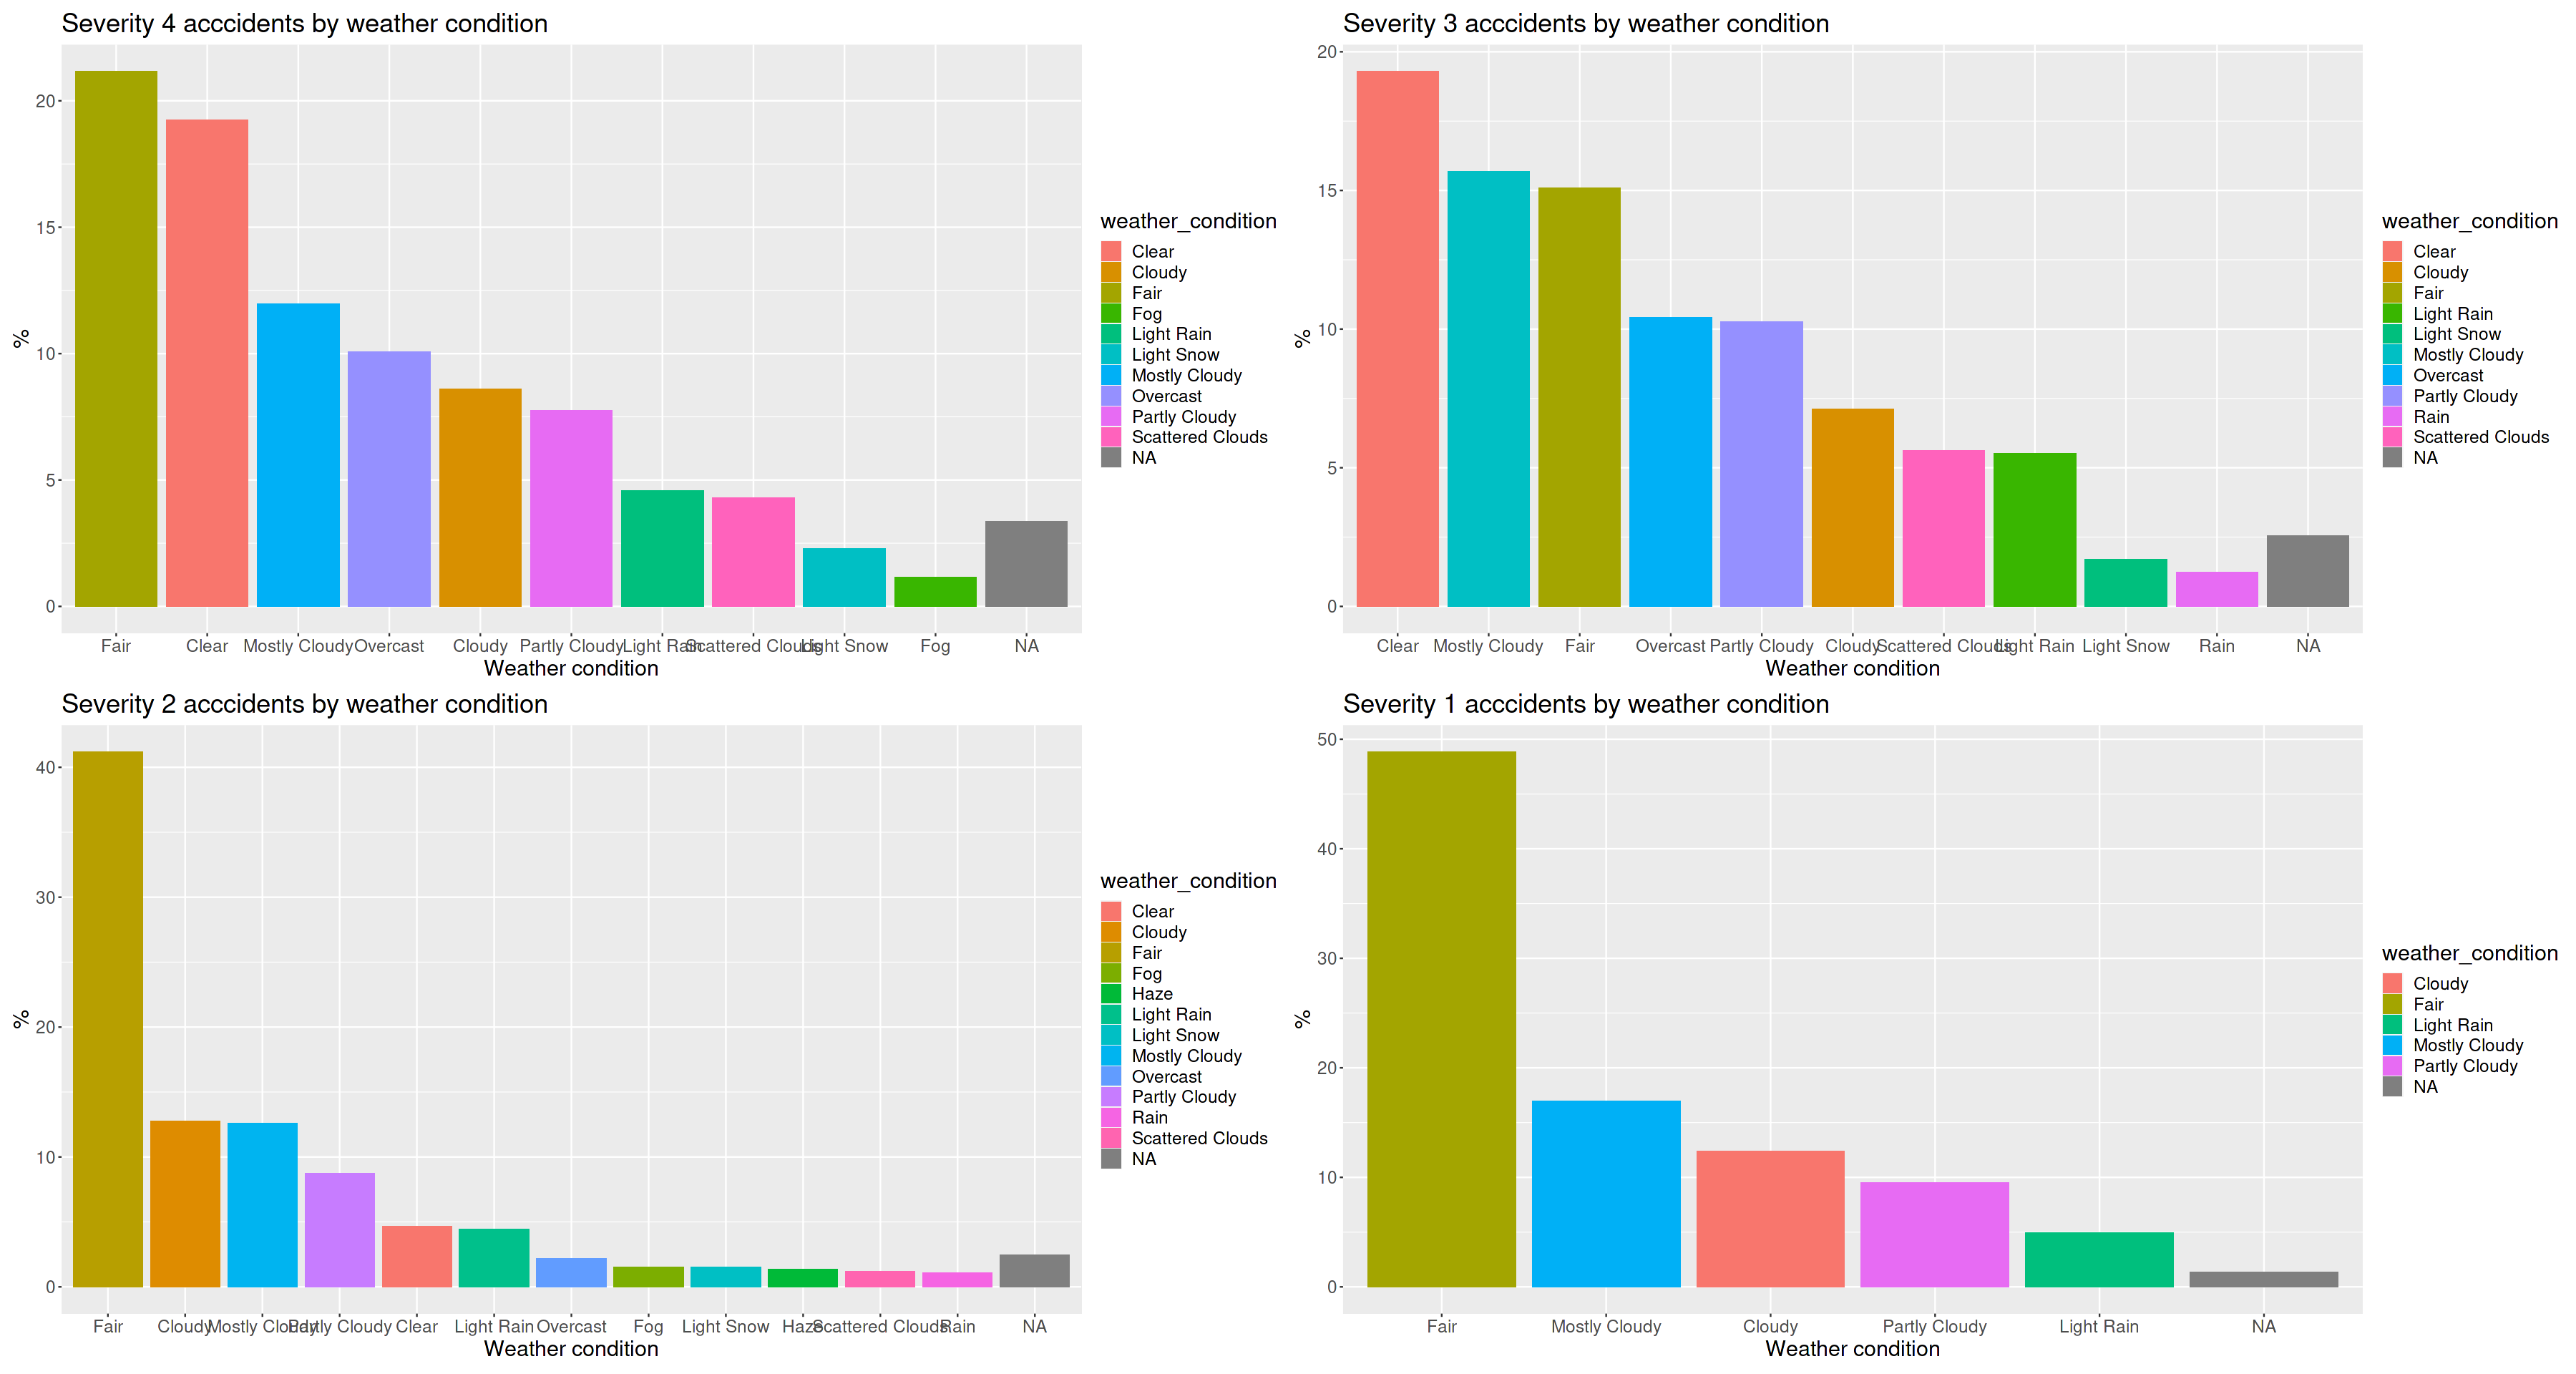

In [42]:
options(repr.plot.width = 30, repr.plot.height = 16)

severity4_weather_plot + severity3_weather_plot +severity2_weather_plot +severity1_weather_plot

## Description wordcloud

We will take the description column to create a wordcloud.

In [43]:
library(tm)
library(wordcloud)

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


The following object is masked from ‘package:httr’:

    content




Due to memory overflow on Kaggle notebook, we took a sample of the dataset to create the wordcloud.

In [44]:
corpus = Corpus(VectorSource(sample(df$description,size=floor(nrow(df)/128))))

In [45]:
corpus = tm_map(corpus, PlainTextDocument)
corpus = tm_map(corpus, tolower)
 
#Removing Punctuation
corpus = tm_map(corpus, removePunctuation)


#Remove stopwords
corpus = tm_map(corpus, removeWords, stopwords("english"))
 
 
# Eliminate white spaces
corpus = tm_map(corpus, stripWhitespace)

Warning message in tm_map.SimpleCorpus(corpus, PlainTextDocument):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, tolower):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”


In [46]:
DTM <- TermDocumentMatrix(corpus)
mat <- as.matrix(DTM)
f <- sort(rowSums(mat),decreasing=TRUE)
dat <- data.frame(word = names(f),freq=f)

We can see some intersting key words on the wordcloud, some of them are abbreviation. We can highlight:

* *pkwy*: Parkway
* *i95*: Interstate 95
* *blvd*: Boulevard
* *i10*: Interstate 10
* *hwy*: Highway
* *fwy*: Freeway
* *us101*: U.S. Route 101
* *rdexit*: Road exit
* *aveexit*: Avenue exit

In [47]:
set.seed(100)
wordcloud2(dat, size = 1.5) 

HTML widgets cannot be represented in plain text (need html)

# Conclusions

The dataset contain 47 columns and 2845342 rows. 8 columns contained missing values, later we learned that 2 other columns contained only a empty character as value and we traeted them as missing values. We analyzed 16 columns avoiding some of the columns with missing values. The columns analyzed were:

1. Weather condition
2. Astronomical_Twilight
3. All the POI annotations (Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop)
4. Description

From these columns we learned that:

* 76% of the accidents occur on fairly normal weather conditions (Fair, Mostly Cloudy, Cloudy, Partly Cloudy, Clear).
* 76% of the accident occur during the day
* Only 26% of the accidents occured close to any of the road elements considered.
* Junctions are the road element where occur more accidents with 9.9%
* Severity 2 is the most recurrent with 89% of the accidents. 
* Accidents with bad weather doesn't have a higher severity.
* Accidents are not more frequent on bad weather conditions.
* From the description wordcloud we learned that:
    * The  U.S. Route 101, Interstate 95 and Interstate 10 are involved in quite some accidents.
    * Parkways, Highways, Freeways, Road exits, Avenue exits are involved in quite some accidents.

# Limitations and future work
* Enrich the analysis by considering more columns like Start_Time, City, and Street.
* Imputate the missing values of the columns already analyzed considering data from other columns:
    * Weather condition: By checking the other weather variables like Precipitation
    * Astronomical_Twilight: By checking the time of the accident and its coordinates.
* Find out the most recurrent roads, cities and states.